In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_colwidth',None)

In [2]:
users = pd.read_csv('../input/book-recommendation-dataset/Users.csv',low_memory=False)
ratings = pd.read_csv('../input/book-recommendation-dataset/Ratings.csv',low_memory=False)
books = pd.read_csv('../input/book-recommendation-dataset/Books.csv',low_memory=False)

In [3]:
print(books.shape)
books.columns=['ISBN','Title','Author','Year_Of_Publication','Publisher','Image_URL_S','Image_URL_M','Image_URL_L']
books.drop(['Image_URL_S','Image_URL_L'],axis=1,inplace=True)
books.head()

(271360, 8)


,ISBN,Title,Author,Year_Of_Publication,Publisher,Image_URL_M
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg


now let us start from books dataframe. first we will check if there are NULL values

In [4]:
L=((books.isnull().sum()).sort_values()).to_dict()
for i in L:
    print(i,"--->",L[i])  

ISBN ---> 0
Title ---> 0
Year_Of_Publication ---> 0
Image_URL_M ---> 0
Author ---> 1
Publisher ---> 2


In [5]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Title                271360 non-null  object
 2   Author               271359 non-null  object
 3   Year_Of_Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image_URL_M          271360 non-null  object
dtypes: object(6)
memory usage: 12.4+ MB


In [6]:
duplicateRowsDF = books[books.duplicated()]
duplicateRowsDF.shape

(0, 6)

we do not have duplicate rows now we will check if the isbn or the title is repeated

In [7]:
print("unique isbn: ",len(books["ISBN"].unique()))
print("total rows: ",books.shape[0])
print("unique title: ",len(books["Title"].unique()))
print("total rows: ",books.shape[0])

unique isbn:  271360
total rows:  271360
unique title:  242135
total rows:  271360


we can see that some titles are repeated

In [8]:
books['Author'].fillna("Unknown",inplace=True)
books['Publisher'].fillna("Unknown",inplace=True)
books.isnull().sum()

ISBN                   0
Title                  0
Author                 0
Year_Of_Publication    0
Publisher              0
Image_URL_M            0
dtype: int64

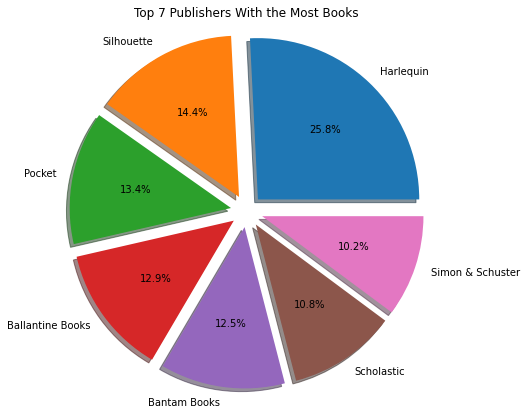

In [9]:
my_dict=(books['Publisher'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['c','count'])
a = count.sort_values(by=['count'], ascending = False)
a.head(7)
labels = 'Harlequin','Silhouette','Pocket','Ballantine Books','Bantam Books','Scholastic','Simon & Schuster'
sizes = [count['count'].iloc[0],count['count'].iloc[1],count['count'].iloc[2],count['count'].iloc[3],count['count'].iloc[4],
         count['count'].iloc[5],count['count'].iloc[6]]
explode = (0.1, 0.1, 0.1, 0.1,0.1, 0.1,0.1 )
fig1 , ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes,
        explode = explode,
        labels = labels,
        autopct = '%1.1f%%',
        shadow = True,
        startangle = 0)
plt.title("Top 7 Publishers With the Most Books")
ax1.axis ('equal')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


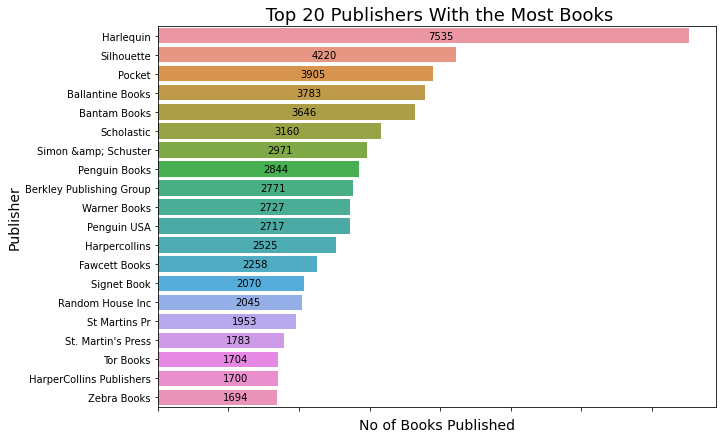

In [10]:
b = count.sort_values(by=['count'], ascending = False)
b = b.head(20)
x =['Harlequin','Silhouette','Pocket','Ballantine Books','Bantam Books','Scholastic','Simon &amp; Schuster']
y = [7537,4220,3905,3783,3646,3160,2971]
fig=plt.figure(figsize=(10,7))
ax = sns.barplot(x = 'count',y = 'c' , data = b)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')
plt.xlabel("No of Books Published", size=14)
plt.ylabel("Publisher", size=14)
plt.title(" Top 20 Publishers With the Most Books", size=18)
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), xy=(p.get_width()/2, p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.show()

In [11]:
np.set_printoptions(threshold=np.inf)
books['Year_Of_Publication'].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', '2038', '2026',
       '1944', '1917', '1901', '2010', '1908', '1906', '1935', '1806',
       '2021', '2012', '2006', 'DK Publishing Inc', 'Gallimard', '1909',
       

we can see that the years are object type and we have zeros as well as there is some error by including names in years 

In [12]:
index=books.loc[books['Year_Of_Publication']=='DK Publishing Inc'].index
books.drop(index,inplace=True)
index=books.loc[books['Year_Of_Publication']=='Gallimard'].index
books.drop(index,inplace=True)
books['Year_Of_Publication'].replace({'0':books['Year_Of_Publication'].value_counts().idxmax()},inplace=True)
books['Year_Of_Publication'] = books['Year_Of_Publication'].astype(str).astype(int)
books['Year_Of_Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030, 1911,
       1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934, 1910,
       1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901, 2010,
       1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378, 1919,
       1922, 1897, 2024, 1376, 2037])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


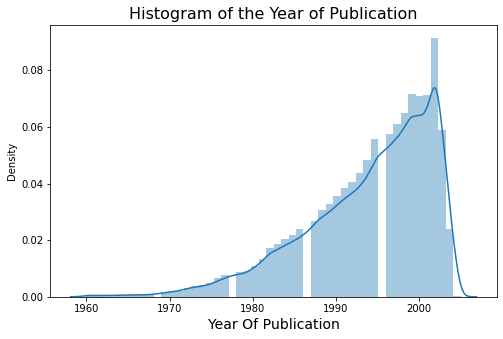

In [13]:
fig=plt.figure(figsize=(8,5))
y1 = books[books['Year_Of_Publication'] >= 1960]
y1 = y1[y1['Year_Of_Publication'] <= 2005]
sns.distplot(y1['Year_Of_Publication'])
plt.xlabel('Year Of Publication',size=14)
plt.title('Histogram of the Year of Publication',size=16)
plt.show()

Now we will analyse users dataset

In [14]:
print(users.shape)
users.columns=['UserID','Location','Age']
users.head()

(278858, 3)


,UserID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   UserID    278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


we will check for null values

In [16]:
L=((users.isnull().sum()).sort_values()).to_dict()
for i in L:
    print(i,"--->",L[i])  

UserID ---> 0
Location ---> 0
Age ---> 110762


In [17]:
users['Age'].fillna(users['Age'].value_counts().idxmax(),inplace=True)
for i in users['Age'][users['Age']>95]:
        users['Age'].replace({i:users['Age'].value_counts().idxmax()},inplace=True)
for i in users['Age'][users['Age']==0]:
        users['Age'].replace({i:users['Age'].value_counts().idxmax()},inplace=True)
users['Age'] = users['Age'].astype(int) 
users['Age'].unique()

array([24, 18, 17, 61, 26, 14, 25, 19, 46, 55, 32, 20, 34, 23, 51, 31, 21,
       44, 30, 57, 43, 37, 41, 54, 42, 50, 39, 53, 47, 36, 28, 35, 13, 58,
       49, 38, 45, 62, 63, 27, 33, 29, 66, 40, 15, 60, 79, 22, 16, 65, 59,
       48, 72, 56, 67,  1, 80, 52, 69, 71, 73, 78,  9, 64, 12, 74, 75,  3,
       76, 83, 68, 11, 77,  2, 70, 93,  8,  7,  4, 81, 10,  5,  6, 84, 82,
       90, 91, 94, 85, 86, 92, 87, 95, 89, 88])

we have cleaned the age values  

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


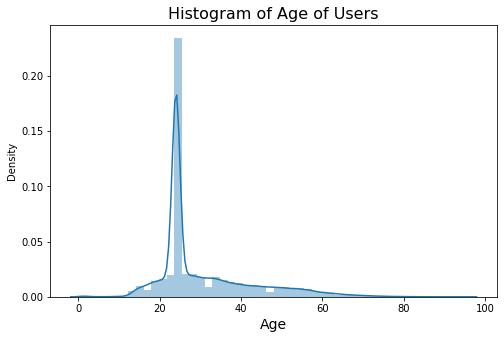

In [18]:
fig=plt.figure(figsize=(8,5))
sns.distplot(users['Age'])
plt.xlabel('Age',size=14)
plt.title('Histogram of Age of Users',size=16)
plt.show()

In [19]:
users['Location']

0                         nyc, new york, usa
1                  stockton, california, usa
2            moscow, yukon territory, russia
3                  porto, v.n.gaia, portugal
4         farnborough, hants, united kingdom
                         ...                
278853                 portland, oregon, usa
278854    tacoma, washington, united kingdom
278855             brampton, ontario, canada
278856             knoxville, tennessee, usa
278857                  dublin, n/a, ireland
Name: Location, Length: 278858, dtype: object

In [20]:
users[['city','state','country','nan','nan','nan','nan','nan','nan']]=users['Location'].apply(lambda x: pd.Series(str(x).split(",")))
users.drop(['Location','nan'],axis=1,inplace=True)
users

,UserID,Age,city,state,country
0,1,24,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,24,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,24,farnborough,hants,united kingdom
...,...,...,...,...,...
278853,278854,24,portland,oregon,usa
278854,278855,50,tacoma,washington,united kingdom
278855,278856,24,brampton,ontario,canada
278856,278857,24,knoxville,tennessee,usa


now we will analyse the ratings columns

In [21]:
print(ratings.shape)
ratings.columns=['UserID','ISBN','Rating']
ratings.head()

(1149780, 3)


,UserID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [22]:
ratings['Rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [23]:
filter1 = ratings[ratings["UserID"].isin(users["UserID"])] 
df_ratings=filter1[filter1["ISBN"].isin(books["ISBN"])] 
df=pd.merge(users,df_ratings,on='UserID')
df

,UserID,Age,city,state,country,ISBN,Rating
0,2,18,stockton,california,usa,0195153448,0
1,8,24,timmins,ontario,canada,0002005018,5
2,8,24,timmins,ontario,canada,0060973129,0
3,8,24,timmins,ontario,canada,0374157065,0
4,8,24,timmins,ontario,canada,0393045218,0
...,...,...,...,...,...,...,...
1031127,278854,24,portland,oregon,usa,0425163393,7
1031128,278854,24,portland,oregon,usa,0515087122,0
1031129,278854,24,portland,oregon,usa,0553275739,6
1031130,278854,24,portland,oregon,usa,0553578596,0


here we merged the ratings and users dataset on UserID

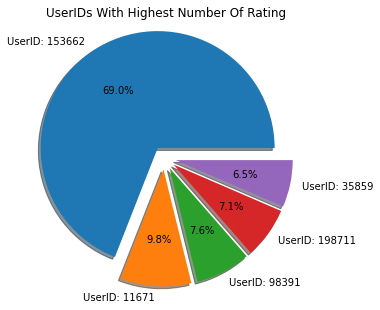

In [24]:
# Pie chart showing countries with most number of users 
my_dict=(df_ratings['Rating'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['c','count'])
a = count.sort_values(by=['count'], ascending = False)
a.head(7)
labels = 'UserID: 153662','UserID: 11671','UserID: 98391','UserID: 198711','UserID: 35859'
sizes = [count['count'].iloc[0],count['count'].iloc[1],count['count'].iloc[2],count['count'].iloc[3],count['count'].iloc[4]]
explode = (0.1, 0.1, 0.1, 0.1,0.1)

fig1 , ax1 = plt.subplots(figsize=(5,5))

ax1.pie(sizes,
        explode = explode,
        labels = labels,
        autopct = '%1.1f%%',
        shadow = True,
        startangle = 0)
plt.title("UserIDs With Highest Number Of Rating")
ax1.axis ('equal')

plt.show()

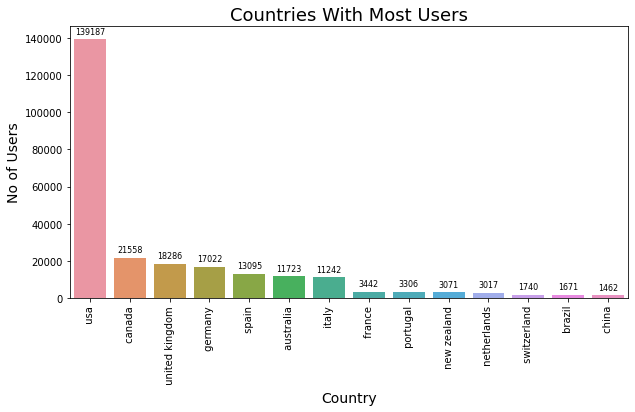

In [25]:
my_dict=(users['country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['c','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
f.drop(7,inplace=True)
fig=plt.figure(figsize=(10,5))
ax = sns.barplot(y = 'count',x= 'c' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 
plt.xlabel("Country", size=14)
plt.ylabel("No of Users", size=14)
plt.title("Countries With Most Users", size=18)
plt.show()

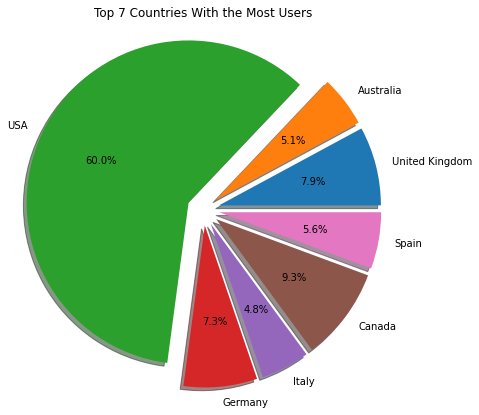

In [26]:
# Pie chart showing countries with most number of users 
my_dict=(users['country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['c','count'])
a = count.sort_values(by=['count'], ascending = False)
a.head(7)
labels = 'United Kingdom','Australia','USA','Germany','Italy','Canada','Spain'
sizes = [count['count'].iloc[2],count['count'].iloc[5],count['count'].iloc[0],count['count'].iloc[3],count['count'].iloc[6],
         count['count'].iloc[1],count['count'].iloc[4]]
explode = (0.1, 0.1, 0.1, 0.1,0.1, 0.1,0.1 )

fig1 , ax1 = plt.subplots(figsize=(7,7))

ax1.pie(sizes,
        explode = explode,
        labels = labels,
        autopct = '%1.1f%%',
        shadow = True,
        startangle = 0)
plt.title("Top 7 Countries With the Most Users")
ax1.axis ('equal')

plt.show()

In [27]:
coun=[]
for country in df["country"].unique():
    coun.append(country)
import pycountry
def do_fuzzy_search(country):
    result = pycountry.countries.search_fuzzy(country)
    return result[0].alpha_3
iso_map=[]
c=[]
for i in coun:
    try:
        iso_map.append(do_fuzzy_search(i))
        c.append(i)
    except:
        iso_map.append('unknown')
        c.append(i)
        continue
df1=pd.DataFrame(iso_map,c,columns=['code'])
df1

,code
usa,USA
canada,CAN
spain,ESP
,GBR
germany,DEU
...,...
andalucia,ESP
mozambique,MOZ
angola,AGO
"italy""",unknown


In [28]:
l=list(df1.index)
country_code=[]
for i in df['country']:
    if i in l:
        country_code.append(df1['code'].loc[df1.index==i][0])
df['Country_Code'] = np.array(country_code)

In [29]:
import pycountry
grouped = df.groupby(['Country_Code','country'])
avg=pd.DataFrame(grouped['Rating'].agg(np.mean))
avg.reset_index(inplace=True)
avg.columns=['Country Code','Country','Average Rating']
import plotly.express as px
fig = px.choropleth(avg, locations=avg['Country Code'],color=avg['Average Rating'],hover_name=avg['Country'],
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

the above map shows the average ratings given by users of a country

In [30]:
import pycountry
grouped = df.groupby(['Country_Code','country'])
avg=pd.DataFrame(grouped['Age'].agg(np.mean))
avg.reset_index(inplace=True)
avg.columns=['Country Code','Country','Average Age']
import plotly.express as px
fig = px.choropleth(avg, locations=avg['Country Code'],color=avg['Average Age'],hover_name=avg['Country'],
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

the above map shows the average age of users of a country

<h2>Popularity Based Recommendation</h2>

recommendations of the books are made based on their popularity among users

In [31]:
a=df[df['Rating']>0]
grouped = a.groupby('ISBN')
popular_books = pd.DataFrame(grouped['Rating'].agg([np.size, np.mean]))
most_popular = popular_books.sort_values(['mean'], ascending=False)
pop=most_popular[most_popular['size']>200]
pop_title=list(pop[:10].index)
titles=[]
for i in pop_title:
    titles.append(books['Title'].loc[books['ISBN']==i].values[0])
index=1
for i in titles:
    print(index,'. ',i)
    index+=1

1 .  Harry Potter and the Order of the Phoenix (Book 5)
2 .  To Kill a Mockingbird
3 .  Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
4 .  The Secret Life of Bees
5 .  The Da Vinci Code
6 .  The Lovely Bones: A Novel
7 .  The Red Tent (Bestselling Backlist)
8 .  The Poisonwood Bible: A Novel
9 .  Where the Heart Is (Oprah's Book Club (Paperback))
10 .  Angels &amp; Demons


<h2>Content Based Recommendation</h2>

here we use a dataset with descriptions of books given to recommend to users new books based on their previous preference 

In [32]:
dataset=pd.read_csv("../input/dataset/dataset.csv")
data1=dataset[['title','description']]
data1

,title,description
0,We,"A seminal work of dystopian fiction that foreshadowed the worst excesses of Soviet Russia, Yevgeny Zamyatin's We is a powerfully inventive vision that has influenced writers from George Orwell to Ayn Rand. This Penguin Classics edition is translated from the Russian with an introduction by Clarence Brown."
1,Stairway to Heaven,"Since earliest times, human beings have pondered the incomprehensible questions of the universe, life . . . and the afterlife. Where did mortal man go to join the immortal Gods? Was the immense and complex structure at Giza an Egyptian Pharaoh's portal to immortality? Or a pulsating beacon built by extraterrestrials for landing on Earth?"
2,Between Death and Life : Conversations with a Spirit,"Offering both comfort to the fearful and confirmation to the curious, this title examines different levels of existence in the spirit realms."
3,The Mythology Of Supernatural : The Signs and Symbols Behind the Popular TV Show,"A look into the paranormal legends, lore, mythology, and monsters featured on the hit television show Supernatural. From angels to demons, The Mythology of Supernatural explores the religious roots and the ancient folklore of the otherworldly entities that brothers Sam and Dean Winchester face on the hit television show Supernatural--and that have inhabited the shadows of human imagination across countless cultures and centuries."
4,The Eagle And The Rose,"'A fascinating spiritual adventure. Rosemary Altea's journey of self-discovery reminds us that our existence is more mysterious than any of us have dared to believe' James Redfield, author of The Celestine Prophecy'I recommend this book.. One cannot deny the importance and truth of its message.' Bernie Siegel, author of Love, Medicine & MiraclesThe Eagle and The Rose is Rosemary Altea's first book, which Rider is now bringing back into print. When it was first published it became an international bestseller, selling well over half a million copies and topping charts all over the world. It will be essential reading for her thousands of fans, especially as it explains her early life and the beginning of her career. She also shows how she contacts the spirit world, predicts future events, performs 'spirit rescues' for those unable to continue their journey and, most of all, she illuminates a plane of infinite goodness, light and wonder beyond everyday life - a place accessible to us all."
...,...,...
20211,Beyond Belief : Islamic Excursions Among the Converted Peoples,"Beyond Belief is a book about one of the more important and unsettling issues of our time. But it is not a book of opinion. It is, in the Naipaul way, a very rich and human book, full of people and their stories: stories of family, both broken and whole; of religion and nation; and of the constant struggle to create a world of virtue and prosperity in equal measure."
20212,An Introduction to the History of Israel and Judah,"Although in this third edition the broad outlines remain the same, changes have been made throughout and the bibliographies have been brought completely up to date. Its strengths lie in a concern for all aspects of the history of Israel and Judah.'"
20213,A History of the Jews and Judaism in the Second Temple Period: Yehud - A History of the Persian Province of Judah v. 1,"In the first of four volumes on A History of the Jews and Judaism in the Second Temple Period, Lester Grabbe presents a comprehensive history of Yehud - the Aramaic name for Judah - during the Persian Period. Among the many crucial questions he addresses are: What are the sources for this period and how do we evaluate them? And how do we make them 'speak' to us through the fog of centuries? This first volume, Yehud: A History of the Persian Province of Judah offers the most up to date and comprehensive examination of the political and administrative structures; the society and economy; the religion, temple and cult; the developments in thought and literature; and t

In [33]:
data1['description'] =data1['description'].astype(str)
data1['len']=data1['description'].apply(lambda x:len(x.split(' ')))
bookdf=data1[data1['len']>=50]
bookdf.shape

(12513, 3)

In [34]:
import spacy as sp
sp.prefer_gpu()
import en_core_web_sm
nlp = en_core_web_sm.load()
import re
def clean_text(doc):
    #Clean the document. Remove pronouns, stopwords, lemmatize the words and lowercase them
    doc = nlp(doc)
    tokens = []
    exclusion_list = ["nan"]
    for token in doc:
        if token.is_stop or token.is_punct or token.text.isnumeric() or (token.text.isalnum()==False) or token.text in exclusion_list :
            continue
        token = str(token.lemma_.lower().strip())
        tokens.append(token)
    return " ".join(tokens) 
bookdf['cleaned_description']=bookdf.apply(lambda row: clean_text(row["description"]) ,axis=1)
bookdf.reset_index(inplace=True)

In [35]:
newdf=bookdf[['title','description','cleaned_description']]

In [36]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
newdf['title_id']=le.fit_transform(newdf['title'])
contentdf=newdf[['title_id','title','description','cleaned_description']]
contentdf=contentdf.set_index('title_id')
contentdf.reset_index(inplace=True)
#contentdf.drop(['index'],axis=1,inplace=True)
contentdf

,title_id,title,description,cleaned_description
0,8334,Stairway to Heaven,"Since earliest times, human beings have pondered the incomprehensible questions of the universe, life . . . and the afterlife. Where did mortal man go to join the immortal Gods? Was the immense and complex structure at Giza an Egyptian Pharaoh's portal to immortality? Or a pulsating beacon built by extraterrestrials for landing on Earth?",early time human being ponder incomprehensible question universe life afterlife mortal man join immortal god immense complex structure giza egyptian pharaoh portal immortality pulsate beacon build extraterrestrial land earth
1,10034,The Mythology Of Supernatural : The Signs and Symbols Behind the Popular TV Show,"A look into the paranormal legends, lore, mythology, and monsters featured on the hit television show Supernatural. From angels to demons, The Mythology of Supernatural explores the religious roots and the ancient folklore of the otherworldly entities that brothers Sam and Dean Winchester face on the hit television show Supernatural--and that have inhabited the shadows of human imagination across countless cultures and centuries.",look paranormal legend lore mythology monster feature hit television supernatural angel demon mythology supernatural explore religious root ancient folklore otherworldly entity brother sam dean winchester face hit television supernatural inhabit shadow human imagination countless culture century
2,9395,The Eagle And The Rose,"'A fascinating spiritual adventure. Rosemary Altea's journey of self-discovery reminds us that our existence is more mysterious than any of us have dared to believe' James Redfield, author of The Celestine Prophecy'I recommend this book.. One cannot deny the importance and truth of its message.' Bernie Siegel, author of Love, Medicine & MiraclesThe Eagle and The Rose is Rosemary Altea's first book, which Rider is now bringing back into print. When it was first published it became an international bestseller, selling well over half a million copies and topping charts all over the world. It will be essential reading for her thousands of fans, especially as it explains her early life and the beginning of her career. She also shows how she contacts the spirit world, predicts future events, performs 'spirit rescues' for those unable to continue their journey and, most of all, she illuminates a plane of infinite goodness, light and wonder beyond everyday life - a place accessible to us all.",fascinating spiritual adventure rosemary altea journey self discovery remind existence mysterious dare believe james redfield author celestine recommend book deny importance truth message bernie siegel author love medicine miraclesthe eagle rose rosemary altea book rider bring print publish international bestseller sell half million copy top chart world essential reading thousand fan especially explain early life beginning career show contact spirit world predict future event perform spirit rescue unable continue journey illuminate plane infinite goodness light wonder everyday life place accessible
3,7865,"Secrets of Antigravity Propulsion : Tesla, UFO's, and Classified Aerospace Technology","In SECRETS OF ANTIGRAVITY PROPULSION, physicist Paul LaViolette reveals the secret history of antigravity experimentation - from Nikola Tesla and T. Townsend Brown to the B-2 Advanced Technology Bomber. He discloses the existence of advanced gravity-control technologies, under secret military development for decades, that could revolutionise air travel and energy production. Included among the secret projects he reveals is the research of Project Skyvault to develop an aerospace propulsion system using intense beams of microwave energy similar to that used by the strange crafts seen flying over Area 51.",secrets antigravity propulsion physicist paul laviolette reveal secret history antigravity experimentation nikola tesla townsend brown advanced technology bomber disclose existence advanced g

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 3), stop_words='english')
tfidf_description = tfidf.fit_transform((contentdf["cleaned_description"])) 
print("Each of the %d text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(tfidf_description.shape))
# Finding cosine similarity between vectors 
from sklearn.metrics.pairwise import cosine_similarity 
cos_sim = linear_kernel(tfidf_description, tfidf_description) 

Each of the 12513 text is represented by 62273 features (TF-IDF score of unigrams and bigrams)


In [38]:
indices = pd.Series(contentdf.index) 
def recommendations(title, cosine_sim = cos_sim): 
    recommended_book = [] 
    index = indices[indices == title].index[0]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending = False) 
    top_10_books = list(similarity_scores.iloc[1:11].index)
    for i in top_10_books: 
        recommended_book.append(list(contentdf.index)[i]) 
    top_5_books=[]
    for i in recommended_book:
        if i not in top_5_books and i!=title:
            top_5_books.append(i)
    recommendbook=[]
    for i in top_5_books:
        recommendbook.append(contentdf['title'][i])
    return recommendbook

In [39]:
book="Stairway to Heaven"
print("Enter a book you liked: ",book)
a=contentdf.loc[contentdf['title']==book]
id=a.index[0]
r=recommendations(id)
print("*****Here are a few recommendations for you*****")
for i,j in zip(r,range(1,len(r)+1)):
    print(j,".",i)

Enter a book you liked:  Stairway to Heaven
*****Here are a few recommendations for you*****
1 . Enlightenment
2 . Daily Life of the Egyptian Gods
3 . Architecture, Astronomy and Sacred Landscape in Ancient Egypt
4 . Everywhere and Everywhen : Adventures in Physics and Philosophy
5 . The Biological Universe : Life in the Milky Way and Beyond
6 . The Great Pyramid Void Enigma : The Mystery of the Hall of the Ancestors
7 . The Book of the Dead
8 . Immortality of the Gods : Legends, Mysteries, and the Alien Connection to Eternal Life
9 . Into the Wild Blue and Beyond : True Stories of Alien Contact and Military Aviation
10 . Cosmology in Antiquity


<h2>Collabrative Filtering Based Recommendation</h2>

here we recommend books to users who have already rated a few books 

In [40]:
df=df[df['Rating']>0]

In [41]:
counts1 = df['UserID'].value_counts()
df= df[df['UserID'].isin(counts1[counts1 > 200].index)]
df

,UserID,Age,city,state,country,ISBN,Rating,Country_Code
10196,4385,33,albq,new mexico,usa,0061083402,10,USA
10198,4385,33,albq,new mexico,usa,0061093343,9,USA
10199,4385,33,albq,new mexico,usa,0061096156,10,USA
10201,4385,33,albq,new mexico,usa,0312956762,10,USA
10202,4385,33,albq,new mexico,usa,0312980353,10,USA
...,...,...,...,...,...,...,...,...
1014234,274061,26,gahanna/columbus,ohio,usa,1892213737,10,USA
1014235,274061,26,gahanna/columbus,ohio,usa,189221394X,10,USA
1014236,274061,26,gahanna/columbus,ohio,usa,1892213958,10,USA
1014237,274061,26,gahanna/columbus,ohio,usa,1892213966,10,USA


In [42]:
len(df['ISBN'].unique())

44306

In [43]:
cdf1=df[['UserID','ISBN','Rating']]
cdf=pd.merge(cdf1,books,on='ISBN')
cdf

,UserID,ISBN,Rating,Title,Author,Year_Of_Publication,Publisher,Image_URL_M
0,4385,0061083402,10,The Bandit's Lady (Harper Monogram),Maureen Child,1995,Harper Mass Market Paperbacks (Mm),http://images.amazon.com/images/P/0061083402.01.MZZZZZZZ.jpg
1,4385,0061093343,9,Fault Lines,Anne Rivers Siddons,1996,HarperTorch,http://images.amazon.com/images/P/0061093343.01.MZZZZZZZ.jpg
2,11676,0061093343,8,Fault Lines,Anne Rivers Siddons,1996,HarperTorch,http://images.amazon.com/images/P/0061093343.01.MZZZZZZZ.jpg
3,4385,0061096156,10,Society of the Mind: A Cyberthriller,Eric L. Harry,1997,Harper Mass Market Paperbacks (Mm),http://images.amazon.com/images/P/0061096156.01.MZZZZZZZ.jpg
4,4385,0312956762,10,Die Hard: With a Vengeance - A Novel,D. Chiel,1995,St Martins Pr,http://images.amazon.com/images/P/0312956762.01.MZZZZZZZ.jpg
...,...,...,...,...,...,...,...,...
58169,274061,1892213737,10,"Cardcaptor Sakura, Number 5",Clamp,2001,Tokyopop,http://images.amazon.com/images/P/1892213737.01.MZZZZZZZ.jpg
58170,274061,189221394X,10,Clover #2,Clamp,2001,Tokyopop,http://images.amazon.com/images/P/189221394X.01.MZZZZZZZ.jpg
58171,274061,1892213958,10,Clover #3,Clamp,2002,Tokyopop,http://images.amazon.com/images/P/1892213958.01.MZZZZZZZ.jpg
58172,274061,1892213966,10,"Clover (Clover, 4)",Clamp,2002,TokyoPop,http://images.amazon.com/images/P/1892213966.01.MZZZZZZZ.jpg


In [44]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
cdf['User_ID']=le.fit_transform(cdf['UserID'])
cdf['title_id']=le.fit_transform(cdf['Title'])
cdf.drop('UserID',axis=1,inplace=True)
cdf

,ISBN,Rating,Title,Author,Year_Of_Publication,Publisher,Image_URL_M,User_ID,title_id
0,0061083402,10,The Bandit's Lady (Harper Monogram),Maureen Child,1995,Harper Mass Market Paperbacks (Mm),http://images.amazon.com/images/P/0061083402.01.MZZZZZZZ.jpg,0,29551
1,0061093343,9,Fault Lines,Anne Rivers Siddons,1996,HarperTorch,http://images.amazon.com/images/P/0061093343.01.MZZZZZZZ.jpg,0,11125
2,0061093343,8,Fault Lines,Anne Rivers Siddons,1996,HarperTorch,http://images.amazon.com/images/P/0061093343.01.MZZZZZZZ.jpg,4,11125
3,0061096156,10,Society of the Mind: A Cyberthriller,Eric L. Harry,1997,Harper Mass Market Paperbacks (Mm),http://images.amazon.com/images/P/0061096156.01.MZZZZZZZ.jpg,0,27212
4,0312956762,10,Die Hard: With a Vengeance - A Novel,D. Chiel,1995,St Martins Pr,http://images.amazon.com/images/P/0312956762.01.MZZZZZZZ.jpg,0,8828
...,...,...,...,...,...,...,...,...,...
58169,1892213737,10,"Cardcaptor Sakura, Number 5",Clamp,2001,Tokyopop,http://images.amazon.com/images/P/1892213737.01.MZZZZZZZ.jpg,117,5731
58170,189221394X,10,Clover #2,Clamp,2001,Tokyopop,http://images.amazon.com/images/P/189221394X.01.MZZZZZZZ.jpg,117,6625
58171,1892213958,10,Clover #3,Clamp,2002,Tokyopop,http://images.amazon.com/images/P/1892213958.01.MZZZZZZZ.jpg,117,6626
58172,1892213966,10,"Clover (Clover, 4)",Clamp,2002,TokyoPop,http://images.amazon.com/images/P/1892213966.01.MZZZZZZZ.jpg,117,6628


In [45]:
from surprise import Reader
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(cdf[['User_ID','title_id','Rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4622  1.4918  1.4958  1.4725  1.4938  1.4832  0.0134  
MAE (testset)     1.0705  1.0889  1.0881  1.0797  1.0919  1.0838  0.0078  
Fit time          5.07    5.07    5.22    5.14    5.10    5.12    0.06    
Test time         0.11    0.11    0.12    0.11    0.39    0.17    0.11    


{'test_rmse': array([1.46216663, 1.49178455, 1.49575571, 1.47245103, 1.49379888]),
 'test_mae': array([1.07046663, 1.08892263, 1.08811742, 1.07965544, 1.0919118 ]),
 'fit_time': (5.073604106903076,
  5.069036960601807,
  5.220303535461426,
  5.144810199737549,
  5.102216482162476),
 'test_time': (0.10572600364685059,
  0.10778546333312988,
  0.11863851547241211,
  0.10735416412353516,
  0.39249110221862793)}

In [46]:
def user_rec(id):
    user= cdf[['ISBN','Title','Author','Year_Of_Publication','Publisher','title_id']].copy()
    user = user.reset_index()
# getting full dataset
    data = Dataset.load_from_df(cdf[['User_ID','title_id','Rating']], reader)
    trainset = data.build_full_trainset()
    svd.fit(trainset)
    user['Estimate_Score'] = user['title_id'].apply(lambda x: svd.predict(id, x).est)
    user = user.drop(['index','title_id'], axis = 1)
    user= user.sort_values('Estimate_Score' , ascending = False)
    counts1 = user['Estimate_Score'].value_counts()
    user = user[user['Estimate_Score'].isin(counts1[counts1 == 1].index)]
    return user.head(10)

In [47]:
pd.set_option('display.max_rows',None) 
Uid=3
print("THE ID OF THE USER: ",Uid)
details=cdf.loc[cdf['User_ID']==Uid]
id=details['User_ID'].iloc[0]
a=user_rec(id)
a.reset_index(inplace=True)
a.drop(['index'],axis=1,inplace=True)
details.reset_index(inplace=True)
details
details.drop(['index','User_ID','title_id','ISBN'],axis=1,inplace=True)
print("\n********************************************USER HAS RATED THESE BOOKs******************************************************")
title_1=list(details['Title'])
rat1=list(details['Rating'])
for i,j in zip(title_1,rat1):
    print(i,'=>',j)
print("\n****************HERE ARE A FEW RECOMMENDATIONS FOR THE USER WITH THE  MOST ESTIMATED POINTS THE USER WILL GIVE******************")

display(a)

THE ID OF THE USER:  3

********************************************USER HAS RATED THESE BOOKs******************************************************
The Runaway Jury => 9
Seven Up (A Stephanie Plum Novel) => 8
MANY WATERS => 7
Dying for Chocolate (Culinary Mysteries (Paperback)) => 8
Wicked: The Life and Times of the Wicked Witch of the West => 7
Cold Comfort Farm => 6
Girl in Hyacinth Blue => 8
To the Nines: A Stephanie Plum Novel => 6
Four To Score (A Stephanie Plum Novel) => 8
Coraline => 9
The Sweet Potato Queens' Book of Love => 7
Two for the Dough => 8
THREE TO GET DEADLY : A Stephanie Plum Novel => 8
The Other Boleyn Girl => 9
The Joy Luck Club => 9
The Kitchen God's Wife => 8
Joshua => 8
Mere Christianity: A revised and enlarged edition, with a new introduction, of the three books, The case for Christianity, Christian behaviour, and Beyond personality => 10
Once upon a More Enlightened Time: More Politically Correct Bedtime Stories => 8
The Boy Next Door => 8
Today I Am a Ma'Am

,ISBN,Title,Author,Year_Of_Publication,Publisher,Estimate_Score
0,0553240838,A Most Contagious Game,Catherine Aird,1983,Bantam Books,8.840247
1,0689831404,The Wind in the Willows (Aladdin Classics),Kenneth Grahame,1999,Aladdin,8.833036
2,0393309061,The Nutmeg of Consolation,Patrick O'Brian,1993,W. W. Norton &amp; Company,8.808069
3,0140178406,Aunt Dimity's Death (Aunt Dimity (Paperback)),Nancy Atherton,1993,Penguin Books,8.671882
4,0807503193,"The Amusement Park Mystery (Boxcar Children Mysteries, 25)",Gertrude Chandler Warner,1992,Albert Whitman &amp; Company,8.653227
5,0449244288,Not a Penny More 4,Jeffrey Archer,1981,Fawcett Books,8.642105
6,0679732411,Gift from the Sea,Anne Morrow Lindbergh,1991,Pantheon Books,8.587219
7,0373705018,"Cry Of The Seagull (Harlequin Superromance, No 501)",Megan Brownley,1992,Harlequin,8.584420
8,0449212599,Miss Melville Regrets,Evelyn E. Smith,1987,Random House,8.570296
9,0671459716,True Stories,Margaret Atwood,1982,Simon &amp; Schuster,8.565620
